In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from highlight_text import fig_text
import seaborn as sns


# modeling routines from Scikit Learn packages
#from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
import sklearn.linear_model 
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, roc_auc_score, auc,confusion_matrix, precision_score,recall_score, f1_score
from math import sqrt  # for root mean-squared error calculation
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import class_weight
import os

from PIL import Image
import urllib
import shap


In [2]:
cwd = os.getcwd()
cwd

os.chdir('/Users/qmaclean/pose_data/')

In [3]:
df = pd.read_csv("throws_data.csv")

In [4]:
model_data = df[['right_shoulder_angle',
                'right_knee_angle','right_hip_angle','ankle_distance','right_arm_distance',
                'right_elbow_hip_distance','left_arm_distance','left_elbow_hip_distance',
                'right_wrist_velocity','right_wrist_acceleration','right_ankle_velocity',
                'right_elbow_angular_velocity','torso_size','slope','throw_class']]

In [5]:
model_data = model_data.dropna()

# Functions

In [6]:
#GIVEN
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)

# Exploratory Data Analysis

/var/folders/w2/9gj9_s892kq_6844_z4szmrh0000gn/T/ipykernel_6492/2382311527.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  top = np.zeros_like(corr, dtype=np.bool)
/var/folders/w2/9gj9_s892kq_6844_z4szmrh0000gn/T/ipykernel_6492/2382311527.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('plot-corr-map.pdf',
/var/folders/w2/9gj9_s892kq_6844_z4szmrh0000gn/T/ipykernel_6492/2382311527.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will becom

<Figure size 432x288 with 0 Axes>

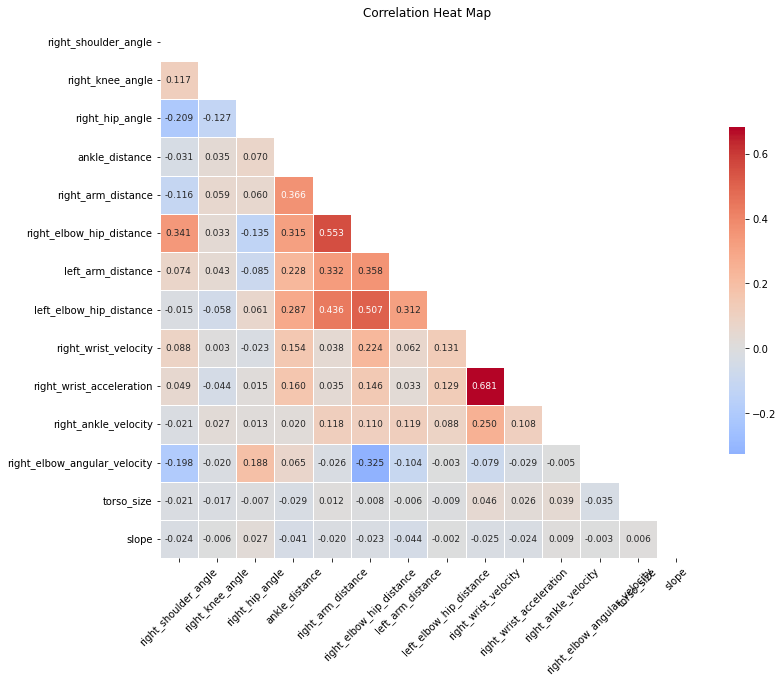

In [7]:
corr_chart(df_corr = model_data) 

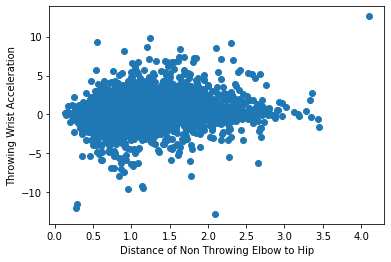

In [8]:
x = model_data['left_elbow_hip_distance']
y = model_data['right_wrist_acceleration']

plt.scatter(x,y)
plt.xlabel('Distance of Non Throwing Elbow to Hip')
plt.ylabel('Throwing Wrist Acceleration')
plt.show()

In [86]:
eda = df.sort_values(by = "row")
eda = eda[eda['drop'] == '2-3 step']

eda = eda.dropna()

/var/folders/w2/9gj9_s892kq_6844_z4szmrh0000gn/T/ipykernel_6492/4121086470.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Y_ea = eda.groupby(['time_cut'])['right_elbow_angle','right_knee_angle'].mean().reset_index().fillna(0)


(-0.5, 859.5, 484.5, -0.5)

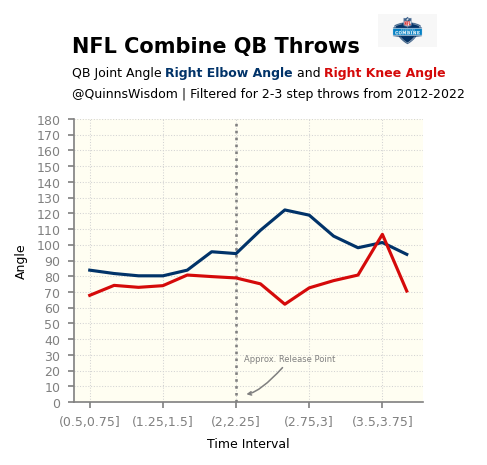

In [144]:
#https://www.sonofacorner.com/tag/tutorials/

Y_ea = eda.groupby(['time_cut'])['right_elbow_angle','right_knee_angle'].mean().reset_index().fillna(0)
Y_ea

x = Y_ea['time_cut']
#Y_ea = eda['right_elbow_angular_velocity'].astype(int)
y = Y_ea['right_elbow_angle']
y2 = Y_ea['right_knee_angle']



fig = plt.figure(figsize=(3,2.5),dpi = 150)
ax = plt.subplot(111,facecolor = "#FFFEF2")

ax.spines[["top", "right"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color("grey")

ax.grid(
    visible = True, 
    lw = 0.5,
    ls = ":",
    color = "lightgrey"
)

ax.tick_params(
    color = "grey", 
    length = 3, 
    which = "major", 
    labelsize = 6,
    labelcolor = "grey",
    zorder = 3
)


ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
# Set y-axis major tick positions to only 0.5 xG multiples.
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
#ax.set_ylim()

line1 = ax.plot(x,y,label="Right Elbow Angle",color = "#013369", zorder = 4)
line2 = ax.plot(x,y2,label="Right Knee Angle",color = "#D50A0A", zorder = 4)        

#ax.legend(fontsize = 6)

ax.set_ylim(0,180)
# Add a line to mark the division between seasons
ax.plot(
    [6,6], # 38 games per season
    [ax.get_ylim()[0], ax.get_ylim()[1]],
    ls = ":",
    lw = 1.25,
    color = "grey",
    zorder = 2
)

# Title and subtitle for the legend
fig_text(
    x = 0.12, y = 1.1,
    s = "NFL Combine QB Throws",
    color = "black",
    weight = "bold",
    size = 10,
    family = "DM Sans", #This is a custom font !!
    annotationbbox_kw={"xycoords": "figure fraction"}
)

ax.annotate(
    xy = (6, 6),
    xytext = (4, 15),
    textcoords = "offset points",
    text = "Approx. Release Point",
    size = 4,
    color = "grey",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # Arrow to connect annotation
)

fig_text(
    x = 0.12, y = 1.02,
    s = "QB Joint Angle <Right Elbow Angle> and <Right Knee Angle> \n@QuinnsWisdom | Filtered for 2-3 step throws from 2012-2022",
    highlight_textprops = [
        {"color": line1[0].get_color(), "weight": "bold"},
        {"color": line2[0].get_color(), "weight": "bold"}
    ],
    color = "black",
    size = 6,
    annotationbbox_kw={"xycoords": "figure fraction"}
)

ax.set_xlabel('Time Interval',size=6)
ax.set_ylabel('Angle',size=6)

url = "https://www.pngitem.com/pimgs/m/291-2910447_2019-nfl-combine-logo-hd-png-download"
#fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"

logo_ax = fig.add_axes([0.8, 1.05, 0.13, 0.13], zorder=1)
club_icon = Image.open(urllib.request.urlopen(f"{url}.png"))
logo_ax.imshow(club_icon)
logo_ax.axis("off")



/var/folders/w2/9gj9_s892kq_6844_z4szmrh0000gn/T/ipykernel_6492/166178904.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Y_ea = eda.groupby(['time_cut'])['right_elbow_angle','right_hip_angle'].mean().reset_index().fillna(0)


(-0.5, 859.5, 484.5, -0.5)

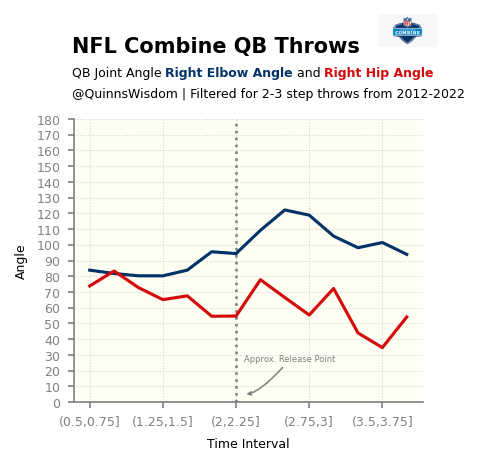

In [145]:
#https://www.sonofacorner.com/tag/tutorials/

Y_ea = eda.groupby(['time_cut'])['right_elbow_angle','right_hip_angle'].mean().reset_index().fillna(0)
Y_ea

x = Y_ea['time_cut']
#Y_ea = eda['right_elbow_angular_velocity'].astype(int)
y = Y_ea['right_elbow_angle']
y2 = Y_ea['right_hip_angle']



fig = plt.figure(figsize=(3,2.5),dpi = 150)
ax = plt.subplot(111,facecolor = "#FFFEF2")

ax.spines[["top", "right"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color("grey")

ax.grid(
    visible = True, 
    lw = 0.5,
    ls = ":",
    color = "lightgrey"
)

ax.tick_params(
    color = "grey", 
    length = 3, 
    which = "major", 
    labelsize = 6,
    labelcolor = "grey",
    zorder = 3
)


ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
# Set y-axis major tick positions to only 0.5 xG multiples.
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
#ax.set_ylim()

line1 = ax.plot(x,y,label="Right Elbow Angle",color = "#013369", zorder = 4)
line2 = ax.plot(x,y2,label="Right Hip Angle",color = "#D50A0A", zorder = 4)        

#ax.legend(fontsize = 6)

ax.set_ylim(0,180)
# Add a line to mark the division between seasons
ax.plot(
    [6,6], # 38 games per season
    [ax.get_ylim()[0], ax.get_ylim()[1]],
    ls = ":",
    lw = 1.25,
    color = "grey",
    zorder = 2
)

# Title and subtitle for the legend
fig_text(
    x = 0.12, y = 1.1,
    s = "NFL Combine QB Throws",
    color = "black",
    weight = "bold",
    size = 10,
    family = "DM Sans", #This is a custom font !!
    annotationbbox_kw={"xycoords": "figure fraction"}
)

ax.annotate(
    xy = (6, 6),
    xytext = (4, 15),
    textcoords = "offset points",
    text = "Approx. Release Point",
    size = 4,
    color = "grey",
    arrowprops=dict(
        arrowstyle="->", shrinkA=0, shrinkB=5, color="grey", linewidth=0.75,
        connectionstyle="angle3,angleA=50,angleB=-30"
    ) # Arrow to connect annotation
)

fig_text(
    x = 0.12, y = 1.02,
    s = "QB Joint Angle <Right Elbow Angle> and <Right Hip Angle> \n@QuinnsWisdom | Filtered for 2-3 step throws from 2012-2022",
    highlight_textprops = [
        {"color": line1[0].get_color(), "weight": "bold"},
        {"color": line2[0].get_color(), "weight": "bold"}
    ],
    color = "black",
    size = 6,
    annotationbbox_kw={"xycoords": "figure fraction"}
)

ax.set_xlabel('Time Interval',size=6)
ax.set_ylabel('Angle',size=6)

url = "https://www.pngitem.com/pimgs/m/291-2910447_2019-nfl-combine-logo-hd-png-download"
#fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"

logo_ax = fig.add_axes([0.8, 1.05, 0.13, 0.13], zorder=1)
club_icon = Image.open(urllib.request.urlopen(f"{url}.png"))
logo_ax.imshow(club_icon)
logo_ax.axis("off")

# Pre-Processing Data

In [146]:
prelim_model_data = np.array([model_data.throw_class,\
    model_data.right_shoulder_angle,\
    model_data.right_knee_angle,\
    model_data.right_hip_angle,\
    model_data.ankle_distance,\
    model_data.right_arm_distance,\
    model_data.right_elbow_hip_distance,\
    model_data.left_arm_distance,\
    model_data.left_elbow_hip_distance,\
    model_data.right_wrist_velocity,\
    model_data.right_wrist_acceleration,\
    model_data.right_ankle_velocity,\
    model_data.right_elbow_angular_velocity,\
    model_data.torso_size,\
    model_data.slope]).T

In [147]:
RANDOM_SEED = 1

X = prelim_model_data[:,1:] #changed to 1 until end, also changed from prelim_model to model
#X
y = prelim_model_data[:,0] #first column is responses, also changed from prelim_model to model
#y

# Encode for string labels
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)



In [148]:
class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced', np.unique(y_train), 
                y_train)))

/Users/qmaclean/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [149]:
class_weights


{0: 0.7153836133906474, 1: 16.795107033639145, 2: 0.6482530689329556}

In [151]:
dtree3 = DecisionTreeClassifier(max_depth=3, max_features = 5, random_state=RANDOM_SEED,class_weight=class_weights)
dtree5 = DecisionTreeClassifier(max_depth=5, max_features = 5, random_state=RANDOM_SEED,class_weight=class_weights)
dtree10 = DecisionTreeClassifier(max_depth=10, max_features = 5, random_state=RANDOM_SEED,class_weight=class_weights)
rf50 = RandomForestClassifier(n_estimators = 50, max_depth=5, max_leaf_nodes=16, n_jobs=-1, random_state=RANDOM_SEED,class_weight=class_weights)
rf100 = RandomForestClassifier(n_estimators = 100, max_leaf_nodes=16, n_jobs=-1, max_depth=5, random_state=RANDOM_SEED,class_weight=class_weights)
rf250 = RandomForestClassifier(n_estimators = 250, max_leaf_nodes=16, n_jobs=-1, max_depth=5, random_state=RANDOM_SEED,class_weight=class_weights)
rf500 = RandomForestClassifier(n_estimators = 500, max_leaf_nodes=16, n_jobs=-1, max_depth=5, random_state=RANDOM_SEED,class_weight=class_weights)
logit = LogisticRegression(random_state=RANDOM_SEED,class_weight=class_weights)
fullSummary = pd.DataFrame()
#set up function to perform modeling
def treeModels(modelName, X_test, y_train, y_test):
    modelName.fit(X_train, y_train)
    y_pred = modelName.predict(X_test)
    #y_pred_prob = modelName.predict_proba(X_test)

    #mse = mean_squared_error(y_test, y_pred)
    cvs = cross_val_score(modelName, X_train, y_train, cv=3, scoring="accuracy")
    cm = confusion_matrix(y_test, y_pred)
    ps = precision_score(y_test, y_pred,average='weighted')
    rs = recall_score(y_test, y_pred,average='weighted')
    f1 = f1_score(y_test, y_pred,average='weighted')
    testScore = modelName.score(X_test, y_test)
    trainScore = modelName.score(X_train, y_train)
    
    
    
    if modelName == dtree3: print('Decision Tree depth 3:')
    elif modelName == dtree5: print('Decision Tree depth 5:')
    elif modelName == dtree10: print('Decision Tree depth 10:')
    elif modelName == rf50: print('Random Forest estimator 50:')
    elif modelName == rf100: print('Random Forest estimator 100:')
    elif modelName == rf250: print('Random Forest estimator 250:')
    elif modelName == rf500: print('Random Forest estimator 500:')
    elif modelName == gb100: print('Gradient Boost estimator 100:')
    elif modelName == gb500: print('Gradient Boost estimator 500:')
    else: return
    
    print('Cross Validation Score: {}'.format(cvs))
    print('Confusion Matrix: {}'.format(cm))
    print('Precision Score: {}'.format(ps))
    print('Recall Score: {}'.format(rs))
    print('F1 Score: {}'.format(f1))
    print('Test Score: {:.5f}'.format(testScore))
    print('Train Score: {:.5f}'.format(trainScore))
    
    summary = pd.DataFrame({'Model':[modelName], 'Precision':[ps], 'Recall':[rs], 'F1':[f1], 'Test Score':[testScore], 'Train Score':[trainScore]})
    
    
    return round(ps, 5), round(rs, 5), round(f1,5), round(testScore, 5), round(trainScore, 5)

In [152]:
ps, rs, f1, testScore, trainScore= treeModels(dtree3, X_test, y_train, y_test)
summary = pd.DataFrame(['Decision Tree depth 3', [ps],[rs], [f1], [testScore], [trainScore]])
fullSummary = fullSummary.append(summary.T)

Decision Tree depth 3:
Cross Validation Score: [0.591 0.587 0.611]
Confusion Matrix: [[358 193  78]
 [  3  19   6]
 [ 96 223 397]]
Precision Score: 0.7901843361931251
Recall Score: 0.5637290604515659
F1 Score: 0.6496274996645253
Test Score: 0.56373
Train Score: 0.57957


In [153]:
ps, rs, f1, testScore, trainScore= treeModels(dtree5, X_test, y_train, y_test)
summary = pd.DataFrame(['Decision Tree depth 5', [ps],[rs], [f1], [testScore], [trainScore]])
fullSummary = fullSummary.append(summary.T)

Decision Tree depth 5:
Cross Validation Score: [0.661 0.692 0.638]
Confusion Matrix: [[384 159  86]
 [  5  14   9]
 [ 57 150 509]]
Precision Score: 0.834783879364806
Recall Score: 0.6605972323379461
F1 Score: 0.7310930803693215
Test Score: 0.66060
Train Score: 0.69264


In [154]:
ps, rs, f1, testScore, trainScore= treeModels(dtree10, X_test, y_train, y_test)
summary = pd.DataFrame(['Decision Tree depth 10', [ps],[rs], [f1], testScore, trainScore])
fullSummary = fullSummary.append(summary.T)

Decision Tree depth 10:
Cross Validation Score: [0.737 0.747 0.773]
Confusion Matrix: [[490  37 102]
 [ 10  10   8]
 [113  28 575]]
Precision Score: 0.8066604447827985
Recall Score: 0.7829570284049526
F1 Score: 0.7934977039479266
Test Score: 0.78296
Train Score: 0.89130


In [155]:
ps, rs, f1, testScore, trainScore= treeModels(rf50, X_test, y_train, y_test)
summary = pd.DataFrame(['Random Forest estimator 50', [ps],[rs], [f1], [testScore], [trainScore]])
fullSummary = fullSummary.append(summary.T)

Random Forest estimator 50:
Cross Validation Score: [0.747 0.748 0.744]
Confusion Matrix: [[415 126  88]
 [  3  19   6]
 [ 74  70 572]]
Precision Score: 0.836108015030608
Recall Score: 0.7327021121631464
F1 Score: 0.7740650801863329
Test Score: 0.73270
Train Score: 0.73944


In [156]:
ps, rs, f1, testScore, trainScore= treeModels(rf100, X_test, y_train, y_test)
summary = pd.DataFrame(['Random Forest estimator 100', [ps],[rs], [f1], [testScore], [trainScore]])
fullSummary = fullSummary.append(summary.T)

Random Forest estimator 100:
Cross Validation Score: [0.732 0.745 0.74 ]
Confusion Matrix: [[415 135  79]
 [  3  20   5]
 [ 74  68 574]]
Precision Score: 0.843165257489158
Recall Score: 0.7348871085214858
F1 Score: 0.7781574986669934
Test Score: 0.73489
Train Score: 0.74272


In [157]:
ps, rs, f1, testScore, trainScore= treeModels(rf250, X_test, y_train, y_test)
summary = pd.DataFrame(['Random Forest estimator 250', [ps],[rs], [f1], [testScore], [trainScore]])
fullSummary = fullSummary.append(summary.T)

Random Forest estimator 250:
Cross Validation Score: [0.736 0.746 0.75 ]
Confusion Matrix: [[413 134  82]
 [  4  19   5]
 [ 68  74 574]]
Precision Score: 0.844666613967318
Recall Score: 0.7327021121631464
F1 Score: 0.777483756424823
Test Score: 0.73270
Train Score: 0.74272


In [158]:
ps, rs, f1, testScore, trainScore= treeModels(rf500, X_test, y_train, y_test)
summary = pd.DataFrame(['Random Forest estimator 500', [ps],[rs], [f1], [testScore], [trainScore]])
fullSummary = fullSummary.append(summary.T)

Random Forest estimator 500:
Cross Validation Score: [0.735 0.742 0.743]
Confusion Matrix: [[413 134  82]
 [  4  19   5]
 [ 73  75 568]]
Precision Score: 0.8400496621370287
Recall Score: 0.7283321194464676
F1 Score: 0.7732923303665973
Test Score: 0.72833
Train Score: 0.73871


In [159]:
fullSummary.rename(columns = {0: 'Model', 1: 'Precision', 2: 'Recall', 3: 'F1 Score', 4: 'Test Score', 5: 'Train Score'}, inplace = True)
fullSummary

,Model,Precision,Recall,F1 Score,Test Score,Train Score
0,Decision Tree depth 3,[0.79018],[0.56373],[0.64963],[0.56373],[0.57957]
0,Decision Tree depth 5,[0.83478],[0.6606],[0.73109],[0.6606],[0.69264]
0,Decision Tree depth 10,[0.80666],[0.78296],[0.7935],0.78296,0.8913
0,Random Forest estimator 50,[0.83611],[0.7327],[0.77407],[0.7327],[0.73944]
0,Random Forest estimator 100,[0.84317],[0.73489],[0.77816],[0.73489],[0.74272]
0,Random Forest estimator 250,[0.84467],[0.7327],[0.77748],[0.7327],[0.74272]
0,Random Forest estimator 500,[0.84005],[0.72833],[0.77329],[0.72833],[0.73871]


In [163]:
shap.initjs()

In [170]:
explainer = shap.Explainer(rf100)
shap_values = explainer(X)

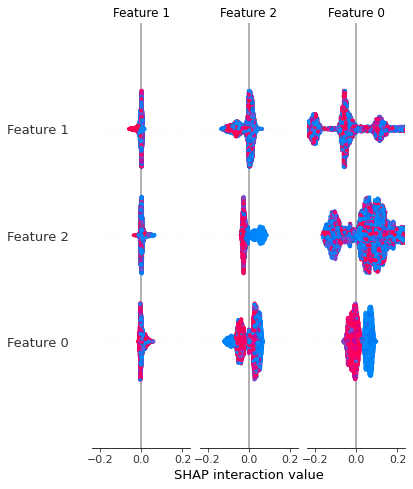

In [175]:
shap.summary_plot(shap_values)